<a href="https://colab.research.google.com/github/Keval1998/Projects_AIP_PRML/blob/master/AgeInvarientFaceRecognization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
path="drive/My Drive/PRML-PRO/"
d=os.listdir(path)
imgg=[]
target=[]
c=0
for i in d:
  print(c)
  c+=1
  img0=cv2.imread(path+i,0)
  imgg.append(img0)
  t=int(i.split(".")[0].split("_")[0].split()[0])
  target.append(t)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pickle
with open("//content//drive//My Drive//prml//data//prml_celeb.pickle",'rb') as f:
  imgg = pickle.load(f)
with open("//content//drive//My Drive//prml//data//prml_celeb_target.pickle",'rb') as f:
  target = pickle.load(f)

In [ ]:
def Hessian2D(I,Sigma):
    if Sigma<1:
        print("error: Sigma<1")
        return -1
    I=np.array(I,dtype=float)
    Sigma=np.array(Sigma,dtype=float)
    S_round=np.round(3*Sigma)
    #print(S_round)
    [X,Y]= np.mgrid[-S_round:S_round+1,-S_round:S_round+1]

    DGaussxx = 1/(2*math.pi*pow(Sigma,4)) * (X**2/pow(Sigma,2) - 1) * np.exp(-(X**2 + Y**2)/(2*pow(Sigma,2)))
    
    DGaussxy = 1/(2*math.pi*pow(Sigma,6)) * (X*Y) * np.exp(-(X**2 + Y**2)/(2*pow(Sigma,2)))   
    DGaussyy = 1/(2*math.pi*pow(Sigma,4)) * (Y**2/pow(Sigma,2) - 1) * np.exp(-(X**2 + Y**2)/(2*pow(Sigma,2)))
  
    Dxx = signal.convolve2d(I,DGaussxx,boundary='fill',mode='same',fillvalue=0)
    Dxy = signal.convolve2d(I,DGaussxy,boundary='fill',mode='same',fillvalue=0)
    Dyy = signal.convolve2d(I,DGaussyy,boundary='fill',mode='same',fillvalue=0)

    return Dxx,Dxy,Dyy


In [ ]:
def eig2image(Dxx,Dxy,Dyy):
    # This function eig2image calculates the eigen values from the
    # hessian matrix, sorted by abs value. And gives the direction
    # of the ridge (eigenvector smallest eigenvalue) .
    # input:Dxx,Dxy,Dyy图像的二阶导数
    # output:Lambda1,Lambda2,Ix,Iy
    #Compute the eigenvectors of J, v1 and v2
    Dxx=np.array(Dxx,dtype=float)
    Dyy=np.array(Dyy,dtype=float)
    Dxy=np.array(Dxy,dtype=float)
    if (len(Dxx.shape)!=2):
        #print("len(Dxx.shape)!=2,Dxx不是二维数组！")
        return 0

    tmp = np.sqrt( (Dxx - Dyy)**2 + 4*Dxy**2)

    v2x = 2*Dxy
    v2y = Dyy - Dxx + tmp

    mag = np.sqrt(v2x**2 + v2y**2)
    i=np.array(mag!=0)

    v2x[i==True] = v2x[i==True]/mag[i==True]
    v2y[i==True] = v2y[i==True]/mag[i==True]

    v1x = -v2y 
    v1y = v2x

    mu1 = 0.5*(Dxx + Dyy + tmp)
    mu2 = 0.5*(Dxx + Dyy - tmp)

    check=abs(mu1)>abs(mu2)
            
    Lambda1=mu1.copy()
    Lambda1[check==True] = mu2[check==True]
    Lambda2=mu2
    Lambda2[check==True] = mu1[check==True]
    
    Ix=v1x
    Ix[check==True] = v2x[check==True]
    Iy=v1y
    Iy[check==True] = v2y[check==True]
    
    return Lambda1,Lambda2,Ix,Iy

In [ ]:
import math
def FrangiFilter2D(I):
    I=np.array(I,dtype=float)
    defaultoptions = {'FrangiScaleRange':(1,10), 'FrangiScaleRatio':2, 'FrangiBetaOne':0.5, 'FrangiBetaTwo':15, 'verbose':True,'BlackWhite':True};  
    options=defaultoptions


    #sigmas=np.arange(options['FrangiScaleRange'][0],options['FrangiScaleRange'][1],options['FrangiScaleRatio'])
   
    sigmas=[1.5,4.5]
    beta  = 2*pow(options['FrangiBetaOne'],2)  
    c     = 2*pow(options['FrangiBetaTwo'],2)

    
    shape=(I.shape[0],I.shape[1],len(sigmas))
    ALLfiltered=np.zeros(shape) 
    ALLangles  =np.zeros(shape) 

    #Frangi filter for all sigmas 
    Rb=0
    S2=0
    for i in range(len(sigmas)):
        #Show progress
        #if(options['verbose']):
        #    print('Current Frangi Filter Sigma: ',sigmas[i])
        
        #Make 2D hessian
        [Dxx,Dxy,Dyy] = Hessian2D(I,sigmas[i])

        #Correct for scale 
        Dxx = pow(sigmas[i],2)*Dxx  
        Dxy = pow(sigmas[i],2)*Dxy  
        Dyy = pow(sigmas[i],2)*Dyy
         
        #Calculate (abs sorted) eigenvalues and vectors  
        [Lambda2,Lambda1,Ix,Iy]=eig2image(Dxx,Dxy,Dyy)  

        #Compute the direction of the minor eigenvector  
        #angles = np.arctan2(Ix,Iy)  

        #Compute some similarity measures  
        Lambda1[Lambda1==0] = np.spacing(1)

        Rb = (Lambda2/Lambda1)**2  
        S2 = Lambda1**2 + Lambda2**2
        
        #Compute the output image
        Ifiltered = np.exp(-Rb/beta) * (np.ones(I.shape)-np.exp(-S2/c))
         
        #see pp. 45  
        if(options['BlackWhite']): 
            Ifiltered[Lambda1<0]=0
        else:
            Ifiltered[Lambda1>0]=0
        
        #store the results in 3D matrices  
        ALLfiltered[:,:,i] = Ifiltered 
       # ALLangles[:,:,i] = angles

        # Return for every pixel the value of the scale(sigma) with the maximum   
        # output pixel value  
        if len(sigmas) > 1:
            outIm=ALLfiltered.max(2)
        else:
            outIm = (ALLfiltered).reshape(I.shape)
            #outIm = (outIm.transpose()).reshape(I.shape)
            
    return outIm


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from scipy import signal
import numpy as np
data1=[]

for i in range(len(imgg)):
  data1.append(FrangiFilter2D(imgg[i]))

In [ ]:
from skimage.filters import frangi
import numpy as np
data1=[]

for i in range(len(imgg)):
  data1.append(frangi(imgg[i]))

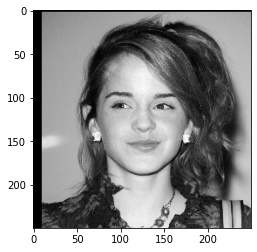

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(imgg[0],cmap="gray")

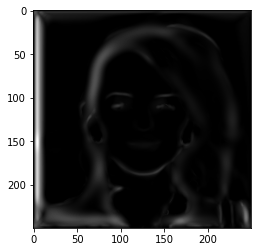

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(data1[0],cmap="gray")

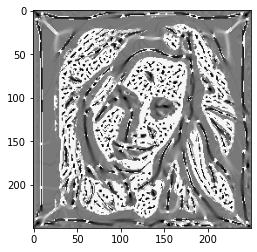

In [ ]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb
import matplotlib.pyplot as plt
# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')



lbp = local_binary_pattern(data1[100], n_points, radius, "uniform")
plt.imshow(lbp,cmap="gray")

In [ ]:
data3=[]
for i in range(len(data1)):
  data3.append(local_binary_pattern(data1[i], n_points, radius, "uniform"))


In [ ]:

data2=[]
for i in range(len(data3)):
  data2.append(data3[i].reshape(250*250))



In [ ]:
data4=np.array(data2)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
fin=pca.fit_transform(data4)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fin, target, test_size=0.3)

In [ ]:
from sklearn.preprocessing import normalize
X_train=normalize(X_train, norm='l2', axis=0, copy=True, return_norm=False)

# **SVM**

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
Y_pred=clf.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,Y_pred))

0.13448275862068965


# **src**

In [ ]:
import cvxpy as cp
import numpy as np


x=cp.Variable((1,X_train.shape[0]))

prob = cp.Problem(cp.Minimize(cp.norm(x,1)),[X_train.T*x.T-X_test[2].reshape(200,1)==0])
optimal_value = prob.solve()

print("x=",x.value)
print("val=",optimal_value)



x= [[ 77.67997747  77.67997738 -11.50588668  77.67997747 -77.67997747
  -77.67997746  77.67997746  77.67997747 -77.67997747  52.87370915
  -77.67997746 -46.05565742  77.67997747  77.67997744  77.67997746
  -77.67997744  77.67997728  69.95381556 -77.67997747 -15.43515124
   77.67997747 -77.67997744  77.67997747  77.67997745  31.28293939
  -77.67997745  77.67997746 -77.67997746  77.67997746 -77.67997747
   31.89364708 -77.67997747 -77.67997746 -77.45928877  77.67997742
  -77.67997747 -64.94388363 -61.70406515 -77.67997747 -77.67997747
  -77.67997732 -60.59392153 -77.67997743 -16.73198256  77.67997747
   77.67997746 -19.02736213 -77.67997744 -77.67997747  77.67997747
   -6.50846163  -0.57837161 -77.67997747  15.82508408 -32.01553437
   22.10565873 -77.67997747 -77.67997747  77.67997747  15.71713997
  -16.45629326 -47.23812914 -77.67997747  28.77886644  77.67997747
   58.48570759  20.11632208  36.39920764 -44.69283611  77.67997746
   77.67997743  77.67997745  18.33637492  77.67997746  -1.1

In [ ]:
from sklearn.metrics import mean_squared_error
def apply_delta(X_train,x,y):
  err=[]
  X_train_1=X_train.copy()
  for c in set(target):
    temp=x.value.copy()
    for i in range(len(X_train_1)):
    #  print(i)
      if y_train[i]!=c:
        temp[0][i]=0
    y_cap=np.dot(X_train_1.T,temp.T)
    err.append(mean_squared_error(y_cap,y))
  return err




In [ ]:
total_class=list(set(target))

y_pred=[]
for i in range(len(X_test)):
  prob = cp.Problem(cp.Minimize(cp.norm(x,1)),[cp.matmul(X_train.T,x.T)==X_test[i].reshape(200,1)])
  optimal_value = prob.solve()
  list_err=apply_delta(X_train,x,X_test[i])
  y_pred.append(total_class[np.argmin(list_err)])
  print(y_pred[-1],y_test[i])



5 7
5 9
8 6
3 4
5 5
5 8
2 2
2 9
5 1
8 5
5 7
5 1
1 3
7 7
2 6
3 3
8 5
5 2
8 6
5 6
8 1
8 5
5 2
5 7
5 5
5 9
5 2
8 6
5 9
5 1
5 7
5 5
8 1
8 5
8 8
5 5
5 5
2 9
8 8
2 7
5 6
8 1
8 8
5 5
8 8
2 2
1 9
8 7
5 5
4 4
5 9
5 1
8 3
8 6
8 7
8 8
8 1
5 1
3 3
2 2
5 1
8 2
8 9
3 3
8 8
3 9
5 8
8 8
5 7
8 1
3 3
5 1
8 8
5 4
2 2
1 7
8 6
3 7
9 4
2 7
4 4
8 2
8 6
8 8
3 9
7 7
5 5
3 2
8 2
5 5
8 8
5 1
5 8
8 3
8 8
5 1
8 2
3 5
5 1
5 7
8 5
8 9
5 4
2 2
8 6
5 5
1 1
5 8
2 5
5 2
5 3
5 4
2 2
5 4
5 8
5 7
4 4
5 9
8 5
8 2
8 8
5 3
3 3
8 1
8 8
1 7
5 7
7 7
5 5
2 8
8 1
9 9
2 5
5 3
5 3
9 9
2 5
5 9
8 2
7 7
5 1
8 1
5 2
2 2
5 6
3 6
5 1
5 8
5 3
3 2
8 6
5 6
5 9
5 1
3 9
5 8
8 8
5 5
5 5
8 8
8 8
8 8
3 2
5 6
3 7
5 6
8 7
2 3
8 8
2 7
5 7
5 5
5 1
8 8
5 7
5 5
3 3
8 8
3 3
2 1
5 7
2 2
3 9
5 2
8 1
3 3
8 1
5 6
8 3
7 7
5 4
8 1
2 2
5 3
2 2
3 3
8 5
5 4
5 7
5 3
2 2
9 9
9 9
1 1
5 1
3 3
8 4
7 7
5 5
1 3
1 1
5 3
3 3
8 3
9 9
5 5
8 5
5 4
8 7
2 1
8 8
8 1
3 7
3 3
8 8
5 4
3 3
5 5
5 9
5 7
5 6
8 6
8 5
4 4
2 2
8 6
5 8
5 9
5 2
8 3
3 3
8 1
5 5
5 9
5 7
3 6
5 3
5 5
5 3
1 4


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.3586206896551724


## **Next Check**